In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv
/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv


In [ ]:
# Import some more libraries
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
# Do not truncate the display of DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [ ]:
# Read the data
train = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv')
test = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv")
inventory = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv")
calendar = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv")
test_weights = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv")
solution = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv")

In [ ]:
# Merge data
train = pd.merge(train, inventory, how='left', on=['unique_id', 'warehouse'])
train = pd.merge(train, calendar, how='left', on=['date', 'warehouse'])
test = pd.merge(test, inventory, how='left', on=['unique_id', 'warehouse'])
test = pd.merge(test, calendar, how='left', on=['date', 'warehouse'])
print(f"Shape of train: {train.shape}")  
print(f"Shape of test: {test.shape}")

Shape of train: (4007419, 25)
Shape of test: (47021, 23)


In [ ]:
# Clean up duplicate columns
y_columns = [col for col in train.columns if col.endswith('_y')]
train = train.drop(columns=y_columns)
test = test.drop(columns=y_columns)
train = train.rename(columns={col: col.replace('_x', '') for col in train.columns if col.endswith('_x')})
test = test.rename(columns={col: col.replace('_x', '') for col in test.columns if col.endswith('_x')})

print(f"Shape of train: {train.shape}")  
print(f"Shape of test: {test.shape}")

Shape of train: (4007419, 25)
Shape of test: (47021, 23)


In [ ]:

# Check for any NaN values after merge
print("NaN values in train:", train.isnull().sum())


NaN values in train: unique_id                       0
date                            0
warehouse                       0
total_orders                   52
sales                          52
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_name_en             0
holiday_name              3844119
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
dtype: int64


In [ ]:
# total_orders and sales only missing for 52 out of 
# 4 million rows is negligible, drop them
train = train.dropna(subset=['total_orders', 'sales'])

In [ ]:
print(train.shape)

(4007367, 25)


In [ ]:
print("NaN values in test:", test.isnull().sum())

NaN values in test: unique_id                     0
date                          0
warehouse                     0
total_orders                  0
sell_price_main               0
type_0_discount               0
type_1_discount               0
type_2_discount               0
type_3_discount               0
type_4_discount               0
type_5_discount               0
type_6_discount               0
product_unique_id             0
name                          0
L1_category_name_en           0
L2_category_name_en           0
L3_category_name_en           0
L4_category_name_en           0
holiday_name              46544
holiday                       0
shops_closed                  0
winter_school_holidays        0
school_holidays               0
dtype: int64


In [ ]:
# Assign holiday_name = NaN a value ("No Holiday") in both train and test
train['holiday_name'] = train['holiday_name'].fillna('No Holiday')
test['holiday_name'] = test['holiday_name'].fillna('No Holiday')

In [ ]:
# Convert date columns to datetime
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
calendar["date"] = pd.to_datetime(calendar["date"])

In [ ]:
# Let's look at basic info about train data
print("Train data shape: ", train.shape)
print("\nFirst few rows of training data:")
train.head()

Train data shape:  (4007367, 25)

First few rows of training data:


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0


In [ ]:
# Train data types:
print(train.dtypes)

unique_id                          int64
date                      datetime64[ns]
warehouse                         object
total_orders                     float64
sales                            float64
sell_price_main                  float64
availability                     float64
type_0_discount                  float64
type_1_discount                  float64
type_2_discount                  float64
type_3_discount                  float64
type_4_discount                  float64
type_5_discount                  float64
type_6_discount                  float64
product_unique_id                  int64
name                              object
L1_category_name_en               object
L2_category_name_en               object
L3_category_name_en               object
L4_category_name_en               object
holiday_name                      object
holiday                            int64
shops_closed                       int64
winter_school_holidays             int64
school_holidays 

In [ ]:
print(test.dtypes)

unique_id                          int64
date                      datetime64[ns]
warehouse                         object
total_orders                     float64
sell_price_main                  float64
type_0_discount                  float64
type_1_discount                  float64
type_2_discount                  float64
type_3_discount                  float64
type_4_discount                  float64
type_5_discount                  float64
type_6_discount                  float64
product_unique_id                  int64
name                              object
L1_category_name_en               object
L2_category_name_en               object
L3_category_name_en               object
L4_category_name_en               object
holiday_name                      object
holiday                            int64
shops_closed                       int64
winter_school_holidays             int64
school_holidays                    int64
dtype: object


In [ ]:
# Date range in train:
print(f"Train dates: {train['date'].min()} to {train['date'].max()}")

Train dates: 2020-08-01 00:00:00 to 2024-06-02 00:00:00


In [ ]:
# Test date range
print(f"Test dates: {test['date'].min()} to {test['date'].max()}")
# Two weeks of data that ends right after train data ends
# Could use last two weeks of train data as validation

Test dates: 2024-06-03 00:00:00 to 2024-06-16 00:00:00


In [ ]:
##### EDA #####

In [ ]:
# Variable to plot
daily_sales = train.groupby("date")["sales"].sum().reset_index()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


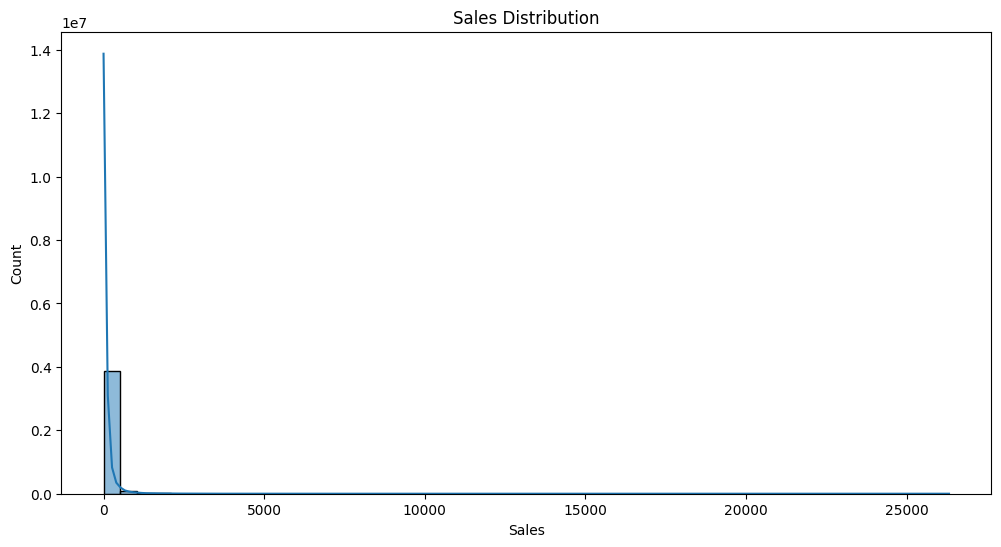

In [ ]:
# Plot sales distribution
plt.figure(figsize=(12,6))
sns.histplot(train["sales"], bins=50, kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.show()

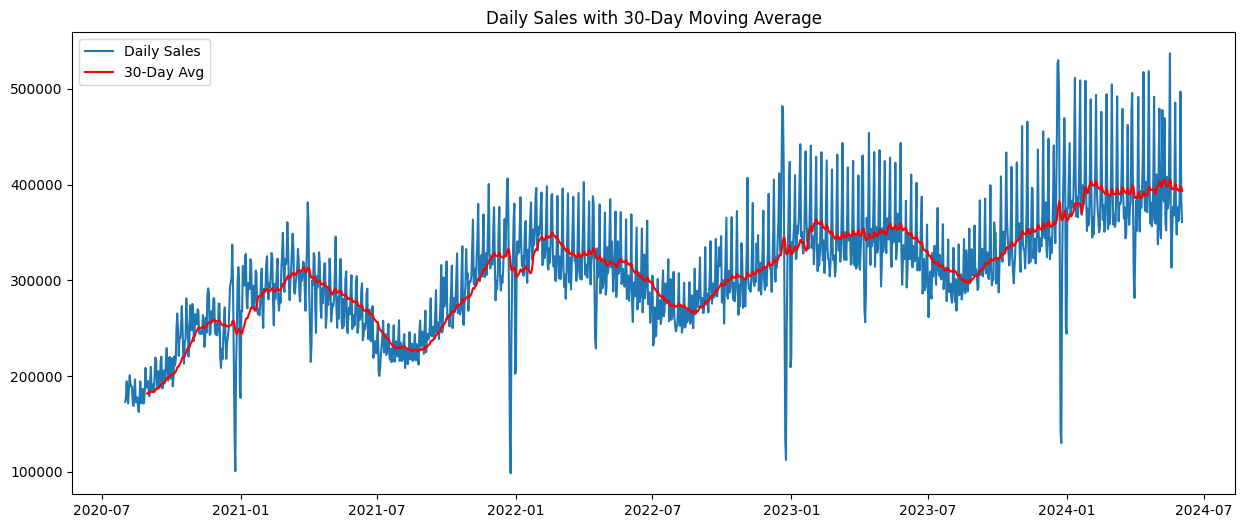

In [ ]:
daily_sales["sales_30d_avg"] = daily_sales["sales"].rolling(30).mean()  # Changed from 7 to 30 days
plt.figure(figsize=(15,6))
plt.plot(daily_sales["date"], daily_sales["sales"], label="Daily Sales")
plt.plot(daily_sales["date"], daily_sales["sales_30d_avg"], label="30-Day Avg", color="red")  # Updated label
plt.title("Daily Sales with 30-Day Moving Average")
plt.legend()
plt.show()

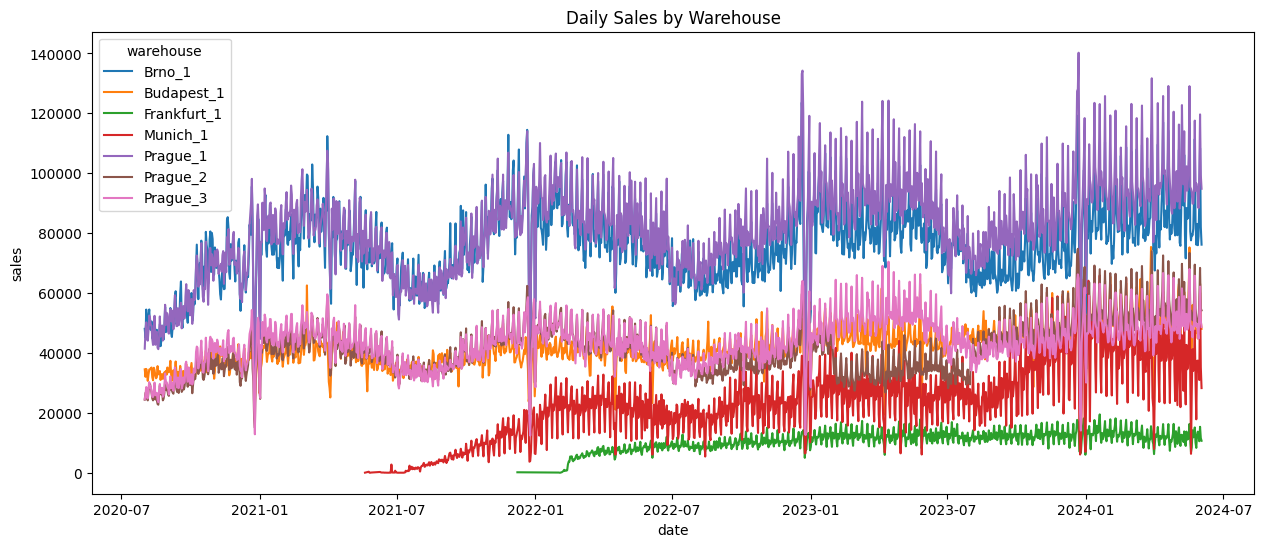

In [ ]:
# Daily sales per warehouse to see the relative volumes
warehouse_daily = train.groupby(["warehouse", "date"])["sales"].sum().reset_index()

# Remove warnings to avoid clutter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Plotting
plt.figure(figsize=(15,6))
sns.lineplot(data=warehouse_daily, x="date", y="sales", hue="warehouse")
plt.title("Daily Sales by Warehouse")
plt.show()

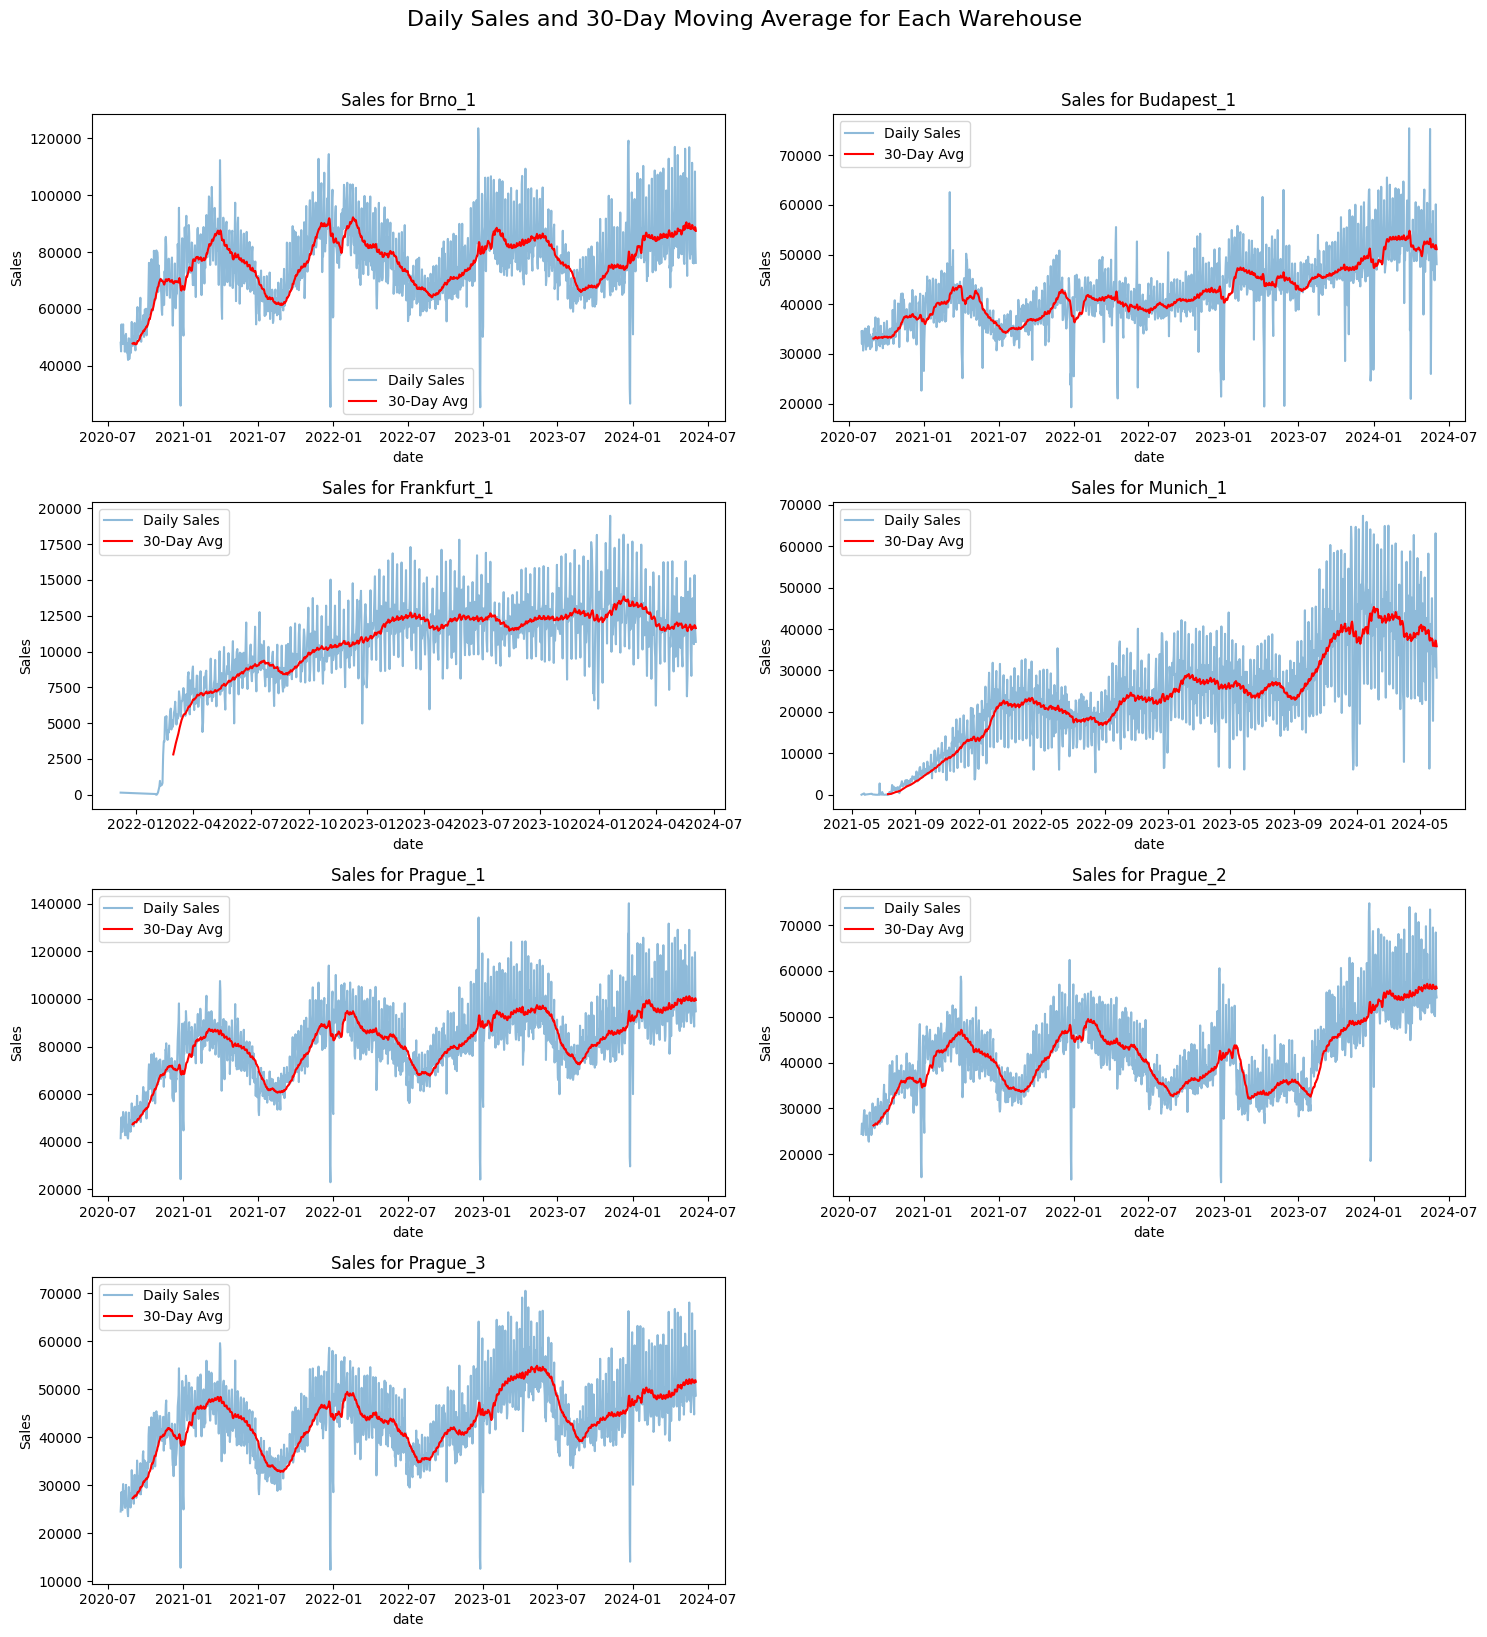

In [ ]:
# Get unique warehouses
warehouses = warehouse_daily["warehouse"].unique()

# Calculate number of rows and columns for subplot grid
n_warehouses = len(warehouses)
n_cols = 2  
n_rows = (n_warehouses + n_cols - 1) // n_cols  # Ceiling division to ensure enough rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
fig.suptitle("Daily Sales and 30-Day Moving Average for Each Warehouse", fontsize=16, y=1.02)  # Add main title
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for idx, (ax, warehouse) in enumerate(zip(axes, warehouses)):
    subset = warehouse_daily[warehouse_daily["warehouse"] == warehouse]
    # Plot daily sales
    sns.lineplot(data=subset, x="date", y="sales", ax=ax, alpha=0.5, label='Daily Sales')
    # Add 30-day moving average
    moving_avg = subset["sales"].rolling(30).mean()
    sns.lineplot(data=subset, x="date", y=moving_avg, ax=ax, color='red', label='30-Day Avg')
    
    ax.set_title(f"Sales for {warehouse}")
    ax.set_ylabel("Sales")
    ax.legend()

# Remove any empty subplots
for idx in range(len(warehouses), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
# Relatively little seasonal variation in Budapest_1 and Frankfurt_1
# Warehouses mostly show a positive sales trend

In [ ]:
# Extract year from date in train and test
train['year'] = train['date'].dt.year
test['year'] = test['date'].dt.year

# Calculate total sales per warehouse per year
warehouse_yearly = train.groupby(['warehouse', 'year'])['sales'].sum().reset_index()

# Calculate company-wide yearly totals
company_yearly = train.groupby('year')['sales'].sum().reset_index()

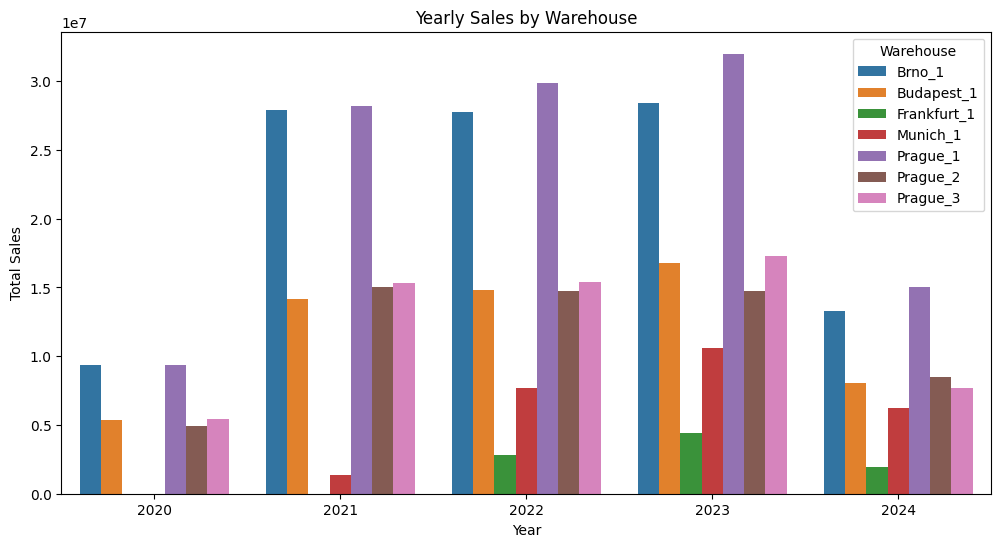

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='sales', hue='warehouse', data=warehouse_yearly)
plt.title('Yearly Sales by Warehouse')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Warehouse')
plt.show()

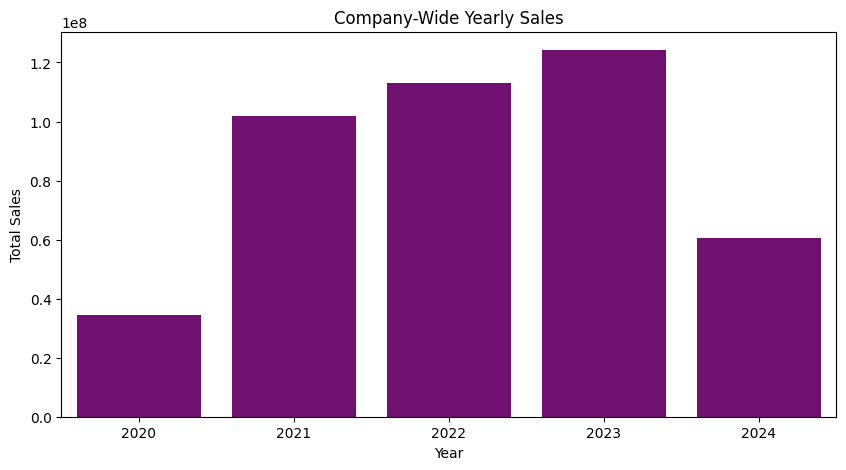

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='sales', data=company_yearly, color='purple')
plt.title('Company-Wide Yearly Sales')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()

# Growth hasn't been that big since 2021,
# could indicate a declining interest since Covid

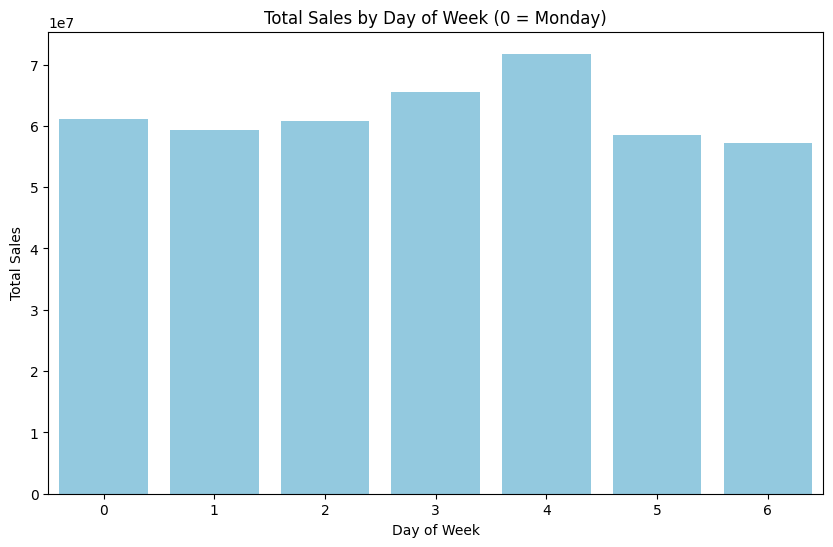

In [ ]:
# Create day_of_week column for train and test
train['day_of_week'] = train['date'].dt.dayofweek  # 0=Monday, 6=Sunday
test['day_of_week'] = test['date'].dt.dayofweek  # 0=Monday, 6=Sunday


# Then calculate total sales per day
daily_sales = train.groupby('day_of_week')['sales'].sum().reset_index()

# Create bar plot
plt.figure(figsize=(10,6))
sns.barplot(x='day_of_week', y='sales', data=daily_sales, color='skyblue')
plt.title('Total Sales by Day of Week (0 = Monday)')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.show()

# Friday is the day with the most volume, weekends the least

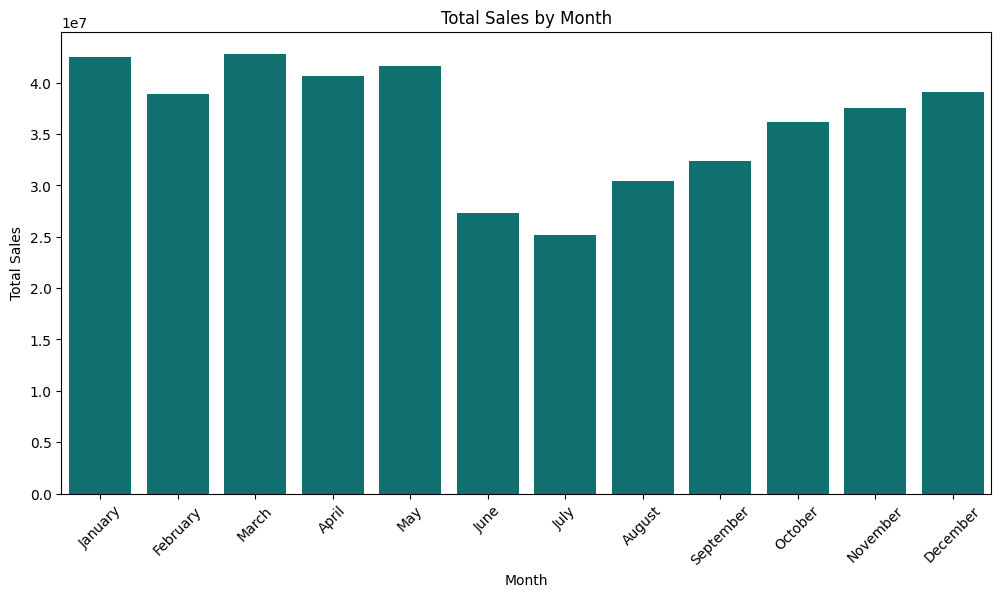

In [ ]:
# Total Sales Per Month

# Extract month from date for train and test
train['month'] = train['date'].dt.month
test['month'] = test['date'].dt.month

# Calculate total sales per month
monthly_sales = train.groupby('month')['sales'].sum().reset_index()

# Map month numbers to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
monthly_sales['month_name'] = monthly_sales['month'].map(month_names)

# Create plot
plt.figure(figsize=(12, 6))
sns.barplot(x='month_name', y='sales', data=monthly_sales, color='teal')
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

# June and July have by far the least volume
# The dates to predict sales for are two weeks in June,
# which might make it more difficult

In [ ]:
# Quick check of discount impact on sales
train['has_any_discount'] = (train[['type_0_discount', 'type_1_discount', 'type_2_discount', 
                                  'type_3_discount', 'type_4_discount', 'type_5_discount', 
                                  'type_6_discount']] > 0).any(axis=1)

print("Average sales with/without discounts:")
print(train.groupby('has_any_discount')['sales'].mean())
# Discounts seem to have a big impact on sales

Average sales with/without discounts:
has_any_discount
False    102.970096
True     140.004171
Name: sales, dtype: float64


In [ ]:
# Quick check of holiday impact
print("\nAverage sales on holidays vs non-holidays:")
print(train.groupby('holiday')['sales'].mean())



Average sales on holidays vs non-holidays:
holiday
0    109.078547
1     91.971093
Name: sales, dtype: float64


In [ ]:
##### END OF EDA #####

In [ ]:
train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,day_of_week,month,has_any_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0,2024,6,3,True
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0,2021,1,5,True
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0,2021,0,12,True
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0,2023,5,4,True
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,No Holiday,0,0,0,0,2022,4,4,True


In [ ]:
test.head()

,unique_id,date,warehouse,total_orders,sell_price_main,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,day_of_week,month
0,1226,2024-06-03,Brno_1,8679.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,No Holiday,0,0,0,0,2024,0,6
1,1226,2024-06-11,Brno_1,8795.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,No Holiday,0,0,0,0,2024,1,6
2,1226,2024-06-13,Brno_1,10009.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,No Holiday,0,0,0,0,2024,3,6
3,1226,2024-06-15,Brno_1,8482.0,13.13,0.15873,0.0,0.0,0.0,0.0,0.0,0.0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,No Holiday,0,0,0,0,2024,5,6
4,1226,2024-06-09,Brno_1,8195.0,13.13,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,627,Croissant_9,Bakery,Bakery_L2_14,Bakery_L3_37,Bakery_L4_1,No Holiday,0,0,0,0,2024,6,6


In [ ]:
for df in [train, test]:
    df['has_any_discount'] = (df[['type_0_discount', 'type_1_discount', 'type_2_discount', 
                                'type_3_discount', 'type_4_discount', 'type_5_discount', 
                                'type_6_discount']] > 0).any(axis=1).astype(int)


In [ ]:
# Sort data by ID and date 
train = train.sort_values(['unique_id', 'date'])
test = test.sort_values(['unique_id', 'date'])

In [ ]:
# Shapes before lag feaures:
print(f"Train shape after lag features: {train.shape}")
print(f"Test shape after lag features: {test.shape}")

Train shape after lag features: (4007367, 29)
Test shape after lag features: (47021, 27)


In [ ]:
# Combine train and test
test['sales'] = np.nan  # Add empty sales column to test
combined_data = pd.concat([train, test]).sort_values(['unique_id', 'date'])

# Create lag features 
combined_data['sales_7days_ago'] = combined_data.groupby('unique_id')['sales'].shift(7)
combined_data['sales_14days_ago'] = combined_data.groupby('unique_id')['sales'].shift(14)
combined_data['sales_28days_ago'] = combined_data.groupby('unique_id')['sales'].shift(28)
combined_data['sales_365days_ago'] = combined_data.groupby('unique_id')['sales'].shift(365)

# 2. Fill NaN values in lag features
for lag_col in ['sales_7days_ago', 'sales_14days_ago', 'sales_28days_ago', 'sales_365days_ago']:
    combined_data[lag_col] = combined_data.groupby('unique_id')[lag_col].fillna(method='ffill')
    combined_data[lag_col] = combined_data[lag_col].fillna(0)  # Fill remaining NaNs with 0


# Split back into train and test
train = combined_data[combined_data['sales'].notna()].copy()
test = combined_data[combined_data['sales'].isna()].copy()

# Drop rows with missing lag features
train = train.dropna()

In [ ]:
# Fill missing lag values in test with mean of recent values
for lag_col in ['sales_7days_ago', 'sales_14days_ago', 'sales_28days_ago', 'sales_365days_ago']:
    combined_data[lag_col] = combined_data.groupby('unique_id')[lag_col].fillna(method='ffill')
    # If still any NaNs, fill with 0
    combined_data[lag_col] = combined_data[lag_col].fillna(0)


In [ ]:
# Shapes after lag feaures:
print(f"Train shape after lag features: {train.shape}")

Train shape after lag features: (4007367, 33)


In [ ]:
# Use last 14 days as validation (same length as test period)
# Could use 2 weeks in June 2023 as sanity check
# Use last 14 days in train as validation
val_start_date = '2024-05-17'
val_mask = train['date'] >= val_start_date
train_data = train[~val_mask]  # Exclude validation period
val_data = train[val_mask]

# Verify the dates
print(f"Train data: {train_data['date'].min()} to {train_data['date'].max()}")
print(f"Validation: {val_data['date'].min()} to {val_data['date'].max()}")
print(f"Test: {test['date'].min()} to {test['date'].max()}")

Train data: 2020-08-01 00:00:00 to 2024-05-16 00:00:00
Validation: 2024-05-17 00:00:00 to 2024-06-02 00:00:00
Test: 2024-06-03 00:00:00 to 2024-06-16 00:00:00


In [ ]:
def prepare_features(df):
    # Prepare features for modeling
    
    # Discount feature if it doesn't exist
    if 'has_any_discount' not in df.columns:
        df['has_any_discount'] = (df[['type_0_discount', 'type_1_discount', 'type_2_discount', 
                                    'type_3_discount', 'type_4_discount', 'type_5_discount', 
                                    'type_6_discount']] > 0).any(axis=1).astype(int)
    
    feature_cols = [
        'day_of_week', 'month', 'year', 
        'has_any_discount', 'holiday', 'shops_closed',
        'winter_school_holidays', 'school_holidays',
        'warehouse', 'total_orders', 'sell_price_main',
        'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en',  
        'sales_7days_ago', 'sales_14days_ago', 'sales_28days_ago', 'sales_365days_ago'  
    ]
    
    return df[feature_cols]


In [ ]:
# Prepare features for each dataset
X_train = prepare_features(train_data)
y_train = train_data['sales']
X_val = prepare_features(val_data)
y_val = val_data['sales']
X_test = prepare_features(test)

In [ ]:
# Merge weights before modeling
train_with_weights = pd.merge(train_data, test_weights, on='unique_id', how='left')
val_with_weights = pd.merge(val_data, test_weights, on='unique_id', how='left')

In [ ]:
# Check that data looks good before modeling:
# Check shapes
print("Shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")

# Check all have same columns
print("\nAll datasets have same columns?")
print(f"X_train columns: {X_train.columns.tolist()}")
print(f"X_val columns: {X_val.columns.tolist()}")
print(f"X_test columns: {X_test.columns.tolist()}")

# Check for any missing values
print("\nMissing values:")
print("X_train:", X_train.isnull().sum().sum())
print("X_val:", X_val.isnull().sum().sum())
print("X_test:", X_test.isnull().sum().sum())

# Quick look at feature ranges
print("\nFeature ranges in train vs test:")
for col in X_train.select_dtypes(include=['int64', 'float64']).columns:
    print(f"\n{col}:")
    print(f"Train range: {X_train[col].min():.2f} to {X_train[col].max():.2f}")
    print(f"Test range: {X_test[col].min():.2f} to {X_test[col].max():.2f}")

Shapes:
X_train: (3950082, 19)
y_train: (3950082,)
X_val: (57285, 19)
y_val: (57285,)
X_test: (47021, 19)

All datasets have same columns?
X_train columns: ['day_of_week', 'month', 'year', 'has_any_discount', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'warehouse', 'total_orders', 'sell_price_main', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'sales_7days_ago', 'sales_14days_ago', 'sales_28days_ago', 'sales_365days_ago']
X_val columns: ['day_of_week', 'month', 'year', 'has_any_discount', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'warehouse', 'total_orders', 'sell_price_main', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'sales_7days_ago', 'sales_14days_ago', 'sales_28days_ago', 'sales_365days_ago']
X_test columns: ['day_of_week', 'month', 'year', 'has_any_discount', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays'

In [ ]:
# Note: No holidays in the test set

In [ ]:
test.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,day_of_week,month,has_any_discount,sales_7days_ago,sales_14days_ago,sales_28days_ago,sales_365days_ago
40599,1,2024-06-03,Frankfurt_1,1725.0,NaN,2.87,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Blueberry_0,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_1,Fruit and vegetable_L4_1,No Holiday,0,0,0,0,2024,0,6,0,164.51,259.50,108.68,0.0
40610,1,2024-06-04,Frankfurt_1,1566.0,NaN,2.87,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Blueberry_0,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_1,Fruit and vegetable_L4_1,No Holiday,0,0,0,0,2024,1,6,0,222.28,162.69,161.44,0.0
40600,1,2024-06-05,Frankfurt_1,1643.0,NaN,2.87,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Blueberry_0,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_1,Fruit and vegetable_L4_1,No Holiday,0,0,0,0,2024,2,6,0,93.87,166.04,96.33,0.0
40602,1,2024-06-06,Frankfurt_1,1763.0,NaN,2.87,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Blueberry_0,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_1,Fruit and vegetable_L4_1,No Holiday,0,0,0,0,2024,3,6,0,141.62,398.24,110.65,0.0
40611,1,2024-06-07,Frankfurt_1,2023.0,NaN,2.87,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Blueberry_0,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_1,Fruit and vegetable_L4_1,No Holiday,0,0,0,0,2024,4,6,0,236.32,101.62,101.37,0.0


In [ ]:
train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,year,day_of_week,month,has_any_discount,sales_7days_ago,sales_14days_ago,sales_28days_ago,sales_365days_ago
3910978,0,2022-07-18,Budapest_1,5289.0,3.97,710.89,0.09,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,No Holiday,0,0,0,0,2022,0,7,0,0.0,0.0,0.0,0.0
3910983,0,2022-07-19,Budapest_1,5255.0,73.36,710.89,1.00,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,No Holiday,0,0,0,0,2022,1,7,0,0.0,0.0,0.0,0.0
3910959,0,2022-07-20,Budapest_1,5334.0,558.09,710.89,0.96,0.0,0.0,0.45045,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,No Holiday,0,0,0,0,2022,2,7,1,0.0,0.0,0.0,0.0
3910961,0,2022-07-21,Budapest_1,5459.0,14.03,710.89,0.06,0.0,0.0,0.45045,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,No Holiday,0,0,0,0,2022,3,7,1,0.0,0.0,0.0,0.0
3910956,0,2022-07-22,Budapest_1,5461.0,558.53,710.89,0.97,0.0,0.0,0.45045,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,No Holiday,0,0,0,0,2022,4,7,1,0.0,0.0,0.0,0.0


In [ ]:
print("Missing values in test features:")
print(X_test.isnull().sum())

Missing values in test features:
day_of_week               0
month                     0
year                      0
has_any_discount          0
holiday                   0
shops_closed              0
winter_school_holidays    0
school_holidays           0
warehouse                 0
total_orders              0
sell_price_main           0
L1_category_name_en       0
L2_category_name_en       0
L3_category_name_en       0
L4_category_name_en       0
sales_7days_ago           0
sales_14days_ago          0
sales_28days_ago          0
sales_365days_ago         0
dtype: int64


In [ ]:
# Check data types before modeling
print(f"X_train types\n: {X_train.dtypes}\n")
print(f"y_train types\n: {y_train.dtypes}\n")
print(f"X_val types\n: {X_val.dtypes}\n")
print(f"y_val types\n: {y_val.dtypes}\n")
print(f"X_test types\n: {X_test.dtypes}\n")

X_train types
: day_of_week                 int32
month                       int32
year                        int32
has_any_discount            int64
holiday                     int64
shops_closed                int64
winter_school_holidays      int64
school_holidays             int64
warehouse                  object
total_orders              float64
sell_price_main           float64
L1_category_name_en        object
L2_category_name_en        object
L3_category_name_en        object
L4_category_name_en        object
sales_7days_ago           float64
sales_14days_ago          float64
sales_28days_ago          float64
sales_365days_ago         float64
dtype: object

y_train types
: float64

X_val types
: day_of_week                 int32
month                       int32
year                        int32
has_any_discount            int64
holiday                     int64
shops_closed                int64
winter_school_holidays      int64
school_holidays             int64
warehouse   

In [ ]:
# TIME TO START MODELING!

In [ ]:
import lightgbm as lgb

In [ ]:
# Define categorical features
categorical_features = ['warehouse', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']

In [ ]:
X_train = X_train.copy()
X_val = X_val.copy()
X_test = X_test.copy()

for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    X_test[col] = X_test[col].astype('category')


In [ ]:
# Train with validation
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8
}


In [ ]:
# Create datasets for LightGBM model
train_dataset = lgb.Dataset(
    X_train, 
    label=y_train,
    categorical_feature=categorical_features,
    weight=train_with_weights['weight']
)

val_dataset = lgb.Dataset(
    X_val, 
    label=y_val,
    categorical_feature=categorical_features,
    weight=val_with_weights['weight']
)


In [ ]:
# Train model
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=100,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(period=10)
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1869
[LightGBM] [Info] Number of data points in the train set: 3950082, number of used features: 19
[LightGBM] [Info] Start training from score 73.659916
Training until validation scores don't improve for 10 rounds
[10]	train's l1: 35.7803	valid's l1: 38.632
[20]	train's l1: 26.8816	valid's l1: 29.4851
[30]	train's l1: 24.4894	valid's l1: 26.9318
[40]	train's l1: 23.6658	valid's l1: 26.0906
[50]	train's l1: 23.2192	valid's l1: 25.7444
[60]	train's l1: 22.9503	valid's l1: 25.4727
[70]	train's l1: 22.7542	valid's l1: 25.2922
[80]	train's l1: 22.592	valid's l1: 25.1625
[90]	train's l1: 22.4668	valid's l1: 25.0507
[100]	train's l1: 22.3482	valid's l1: 24.9602
Did not meet early stopping. Best iteration is:
[100]	train's l1: 22.3482	valid's

In [ ]:
# WMAE using only L1_category_name as name of internal category,
# was 26.3358, using all 4 showed improvement

In [ ]:
# Check feature importances
importance = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

<Figure size 1200x600 with 0 Axes>

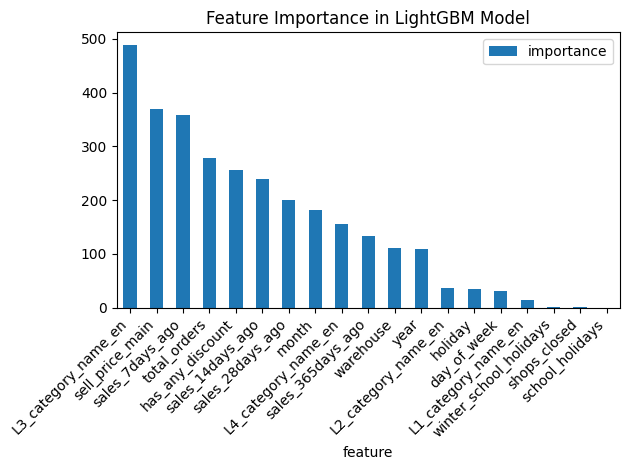

In [ ]:
import matplotlib.pyplot as plt

# Create bar plot of feature importances
plt.figure(figsize=(12, 6))
importance.plot(kind='bar', x='feature', y='importance')
plt.title('Feature Importance in LightGBM Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# The L3 granularity category name is the most important feature,
# followed by sell price and sales from 7 days ago

In [ ]:
# Make predictions and create submission
test_predictions = model.predict(X_test)

In [ ]:
# Create submission file
test_ids = test['unique_id'].astype(str) + '_' + test['date'].dt.strftime('%Y-%m-%d')
submission = pd.DataFrame({
    'id': test_ids,
    'sales_hat': test_predictions
})

In [ ]:
# Quick sanity check
print("Submission sample:")
print(submission.head())
print("\nShape:", submission.shape)
print("\nCheck for any negative predictions:")
print((submission['sales_hat'] < 0).sum())


Submission sample:
                 id   sales_hat
40599  1_2024-06-03  158.067957
40610  1_2024-06-04  180.106967
40600  1_2024-06-05  105.189158
40602  1_2024-06-06  154.847312
40611  1_2024-06-07  141.089562

Shape: (47021, 2)

Check for any negative predictions:
0


In [ ]:
# Save submission
submission.to_csv('submission.csv', index=False)